# 加载Diffusion模型

In [3]:
import torch
from diffusers import DiffusionPipeline, AutoencoderTiny

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device}")

pipe = DiffusionPipeline.from_pretrained(
    "stabilityai/stable-diffusion-2-1-base", torch_dtype=torch.float16,
    local_files_only=True
).to(device)

print(pipe)

Using cuda


Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

StableDiffusionPipeline {
  "_class_name": "StableDiffusionPipeline",
  "_diffusers_version": "0.27.2",
  "_name_or_path": "stabilityai/stable-diffusion-2-1-base",
  "feature_extractor": [
    "transformers",
    "CLIPImageProcessor"
  ],
  "image_encoder": [
    null,
    null
  ],
  "requires_safety_checker": false,
  "safety_checker": [
    null,
    null
  ],
  "scheduler": [
    "diffusers",
    "PNDMScheduler"
  ],
  "text_encoder": [
    "transformers",
    "CLIPTextModel"
  ],
  "tokenizer": [
    "transformers",
    "CLIPTokenizer"
  ],
  "unet": [
    "diffusers",
    "UNet2DConditionModel"
  ],
  "vae": [
    "diffusers",
    "AutoencoderKL"
  ]
}



# 加载Tiny VAE

In [4]:
pipe.vae = AutoencoderTiny.from_pretrained("madebyollin/taesd", local_files_only=True, torch_dtype=torch.float16)
pipe = pipe.to("cuda")

print(pipe.vae)


AutoencoderTiny(
  (encoder): EncoderTiny(
    (layers): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): AutoencoderTinyBlock(
        (conv): Sequential(
          (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): ReLU()
          (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (3): ReLU()
          (4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        )
        (skip): Identity()
        (fuse): ReLU()
      )
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (3): AutoencoderTinyBlock(
        (conv): Sequential(
          (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): ReLU()
          (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (3): ReLU()
          (4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  

# 推理，生成图片

  0%|          | 0/25 [00:00<?, ?it/s]

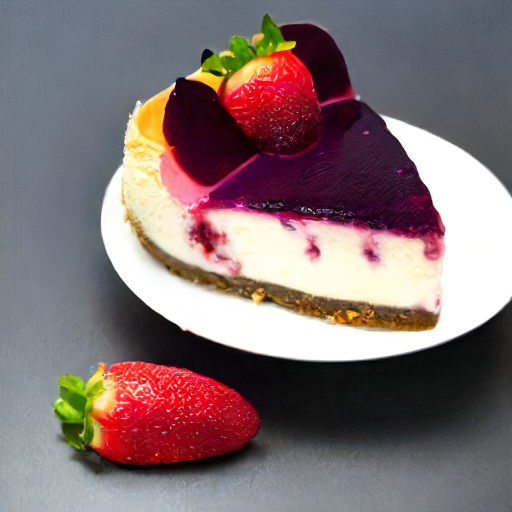

In [5]:
prompt = "slice of delicious New York-style berry cheesecake"
image = pipe(prompt, num_inference_steps=25).images[0]
image

# 加载图片

Original image size: (2160, 2160)


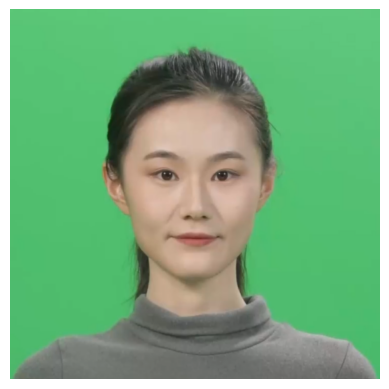

In [6]:
import matplotlib.pyplot as plt
from PIL import Image
from torchvision.transforms import Compose, Lambda, Resize, ToTensor

# 1. 加载图片
input_image_path = "assets/girl.png"  # 替换为您的图片路径
input_image = Image.open(input_image_path).convert("RGB")

# 2. 打印原始图片尺寸
print(f"Original image size: {input_image.size}")

# 2. 显示图片
plt.imshow(input_image)
plt.axis("off")
plt.show()

# 图片预处理

In [19]:
# 1. 图片预处理
image_size = 512

def preprocess(image, image_size):
    transform = Compose([
        Resize(image_size),
        ToTensor(),
        # Lambda(lambda t: (t * 2.0) - 1.0),  # 将图像像素值从[0, 1]缩放到[-1, 1]
    ])
    return transform(image).unsqueeze(0)  # 增加批次维度

input_tensor = preprocess(input_image, image_size)
input_tensor = input_tensor.to(device).half()

# 2. 打印输入张量的形状
print(input_tensor.shape, input_tensor.dtype)
print(input_tensor.min(), input_tensor.max())

torch.Size([1, 3, 512, 512]) torch.float16
tensor(0.0314, device='cuda:0', dtype=torch.float16) tensor(0.8823, device='cuda:0', dtype=torch.float16)


# 用VAE编码和解码，并计算L1 loss

In [20]:
import torch

# 1. 编码与解码
with torch.no_grad():
    # 编码
    latents = pipe.vae.encode(input_tensor).latents
    
    # 打印潜在向量的形状
    print("Latents shape:", latents.shape)
    
    # 解码
    output_tensor = pipe.vae.decode(latents).sample
    
    # 打印输出张量的形状
    print("Output shape:", output_tensor.shape)
    print(output_tensor.min(), output_tensor.max())

# 2. 计算L1 Loss
l1_loss = torch.nn.functional.l1_loss(input_tensor, output_tensor)

print(f"L1 Loss: {l1_loss.item()}")

Latents shape: torch.Size([1, 4, 64, 64])
Output shape: torch.Size([1, 3, 512, 512])
tensor(-0.1479, device='cuda:0', dtype=torch.float16) tensor(1.0059, device='cuda:0', dtype=torch.float16)
L1 Loss: 0.06298828125


# 显示图片

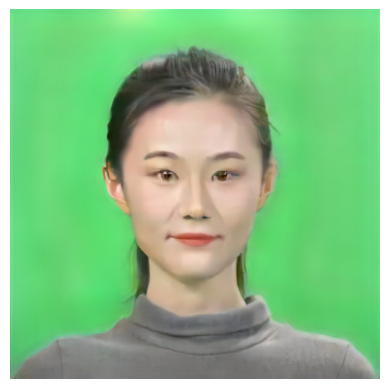

In [21]:
# 1. 创建输出图片
output_image = (output_tensor.squeeze(0).clamp(0, 1) * 255).permute(1, 2, 0).byte().cpu().numpy()
output_image = Image.fromarray(output_image)

# 2. 显示输出图片
plt.imshow(output_image)
plt.axis("off")
plt.show()

# 对比输入与输出图片

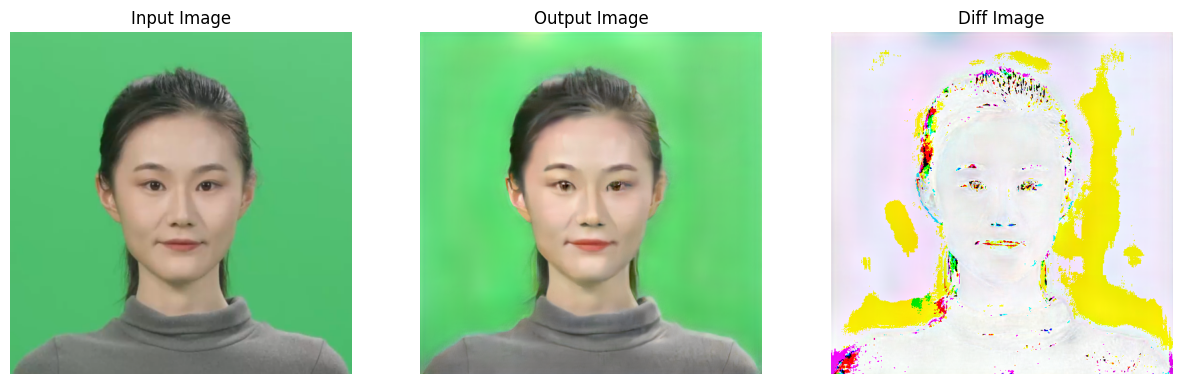

In [22]:
import numpy as np

# 将input_image缩放到image_size
input_image = input_image.resize((image_size, image_size))

# 将 PIL 图片对象转换为 NumPy 数组以便处理
input_image_array = np.asarray(input_image)
output_image_array = np.asarray(output_image)

# 计算差异图片
diff_image_array = np.abs(input_image_array - output_image_array)

# 创建一个图像和子图
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# 显示输入图片
axes[0].imshow(input_image_array)
axes[0].set_title("Input Image")
axes[0].axis("off")

# 显示输出图片
axes[1].imshow(output_image_array)
axes[1].set_title("Output Image")
axes[1].axis("off")

# 显示差异图片
# 注意：为了更好地可视化差异，您可以根据需要调整 diff_image_array 的缩放或映射方式
axes[2].imshow(diff_image_array)
axes[2].set_title("Diff Image")
axes[2].axis("off")

# 显示所有图片
plt.show()